In [1]:
import tensorflow as tf
from model import LabelEncoder, Anchor
from utils import data_preprocess, data_generator
import numpy as np 
import tensorflow_datasets as tfds
import model.Model as Model
import model.Loss as Loss
import os

data_dir = r'F:\dataset\kitti\data_object_image_2\training'
model_dir = r'retinanet\\'
label_encoder = LabelEncoder.LabelEncoder()

num_classes = 8
batch_size = 8


In [2]:
# get data list
img_list = tf.io.gfile.glob(f'{data_dir}\image_2\*.png')
label_list = tf.io.gfile.glob(f'{data_dir}\label_2\*.txt')
img_list.sort()
label_list.sort()

In [3]:
# img, labels, classes = data_preprocess.prepare_data(img_list[0],label_list[0])
# ax = data_preprocess.visualize_detections(img, labels)

In [4]:
learning_rate = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values = learning_rate
)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
train_dataset = data_generator.get_dataset(img_list[:5000], label_list[:5000])
train_dataset = train_dataset.padded_batch(
    batch_size = batch_size, padding_values = (0.0, 1e-8, -1.0), drop_remainder=True
)

# sample = next(iter(train_dataset))
# image, label = label_encoder.encode_batch(sample[0], sample[1], sample[2])
# anchorbox = Anchor.AnchorBox()
# anchors = anchorbox.get_anchors(sample[0][1].shape[0], sample[0][1].shape[1])
# anchors_select = tf.gather(anchors[:,:4], tf.where(label[1,:,4]>0), axis=0)
# anchors_select = anchors_select[:,0,:]
# data_preprocess.visualize_detections(sample[0][1], anchors_select, is_anchors=True)

train_dataset = train_dataset.map(label_encoder.encode_batch)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = data_generator.get_dataset(img_list[5000:6000], label_list[5000:6000])
val_dataset = val_dataset.padded_batch(
    batch_size = batch_size, padding_values = (0.0, 1e-8, -1.0), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [12]:
resnet50_backbone = Model.get_backbone()
loss_fn = Loss.RetinaNetLoss(num_classes)
model = Model.RetinaNet(num_classes, backbone = resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer= optimizer)

In [13]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

In [8]:
model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=10,
    callbacks = callbacks_list,
    verbose = 1,
)

In [9]:
from model.Model import DecodePredictions
weights_dir = 'retinanet'

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)
image = tf.keras.Input(shape=[None, None, 3], name='image')
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold = 0.5, num_classes = num_classes)(image, predictions)
inference_model = tf.keras.Model(inputs= image, outputs=detections)


1/1 [==============================] - 10s 10s/step


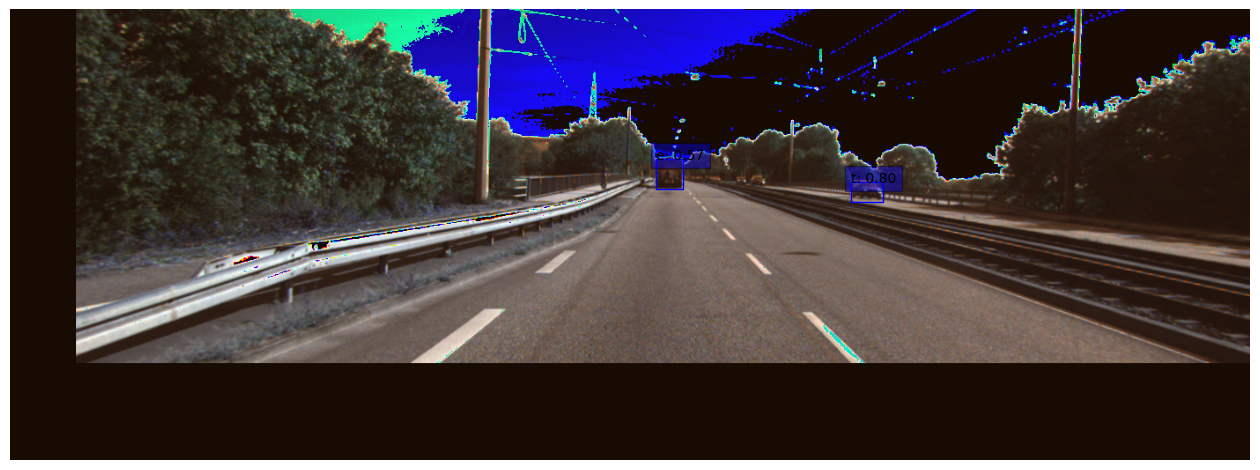

1/1 [==============================] - 0s 56ms/step


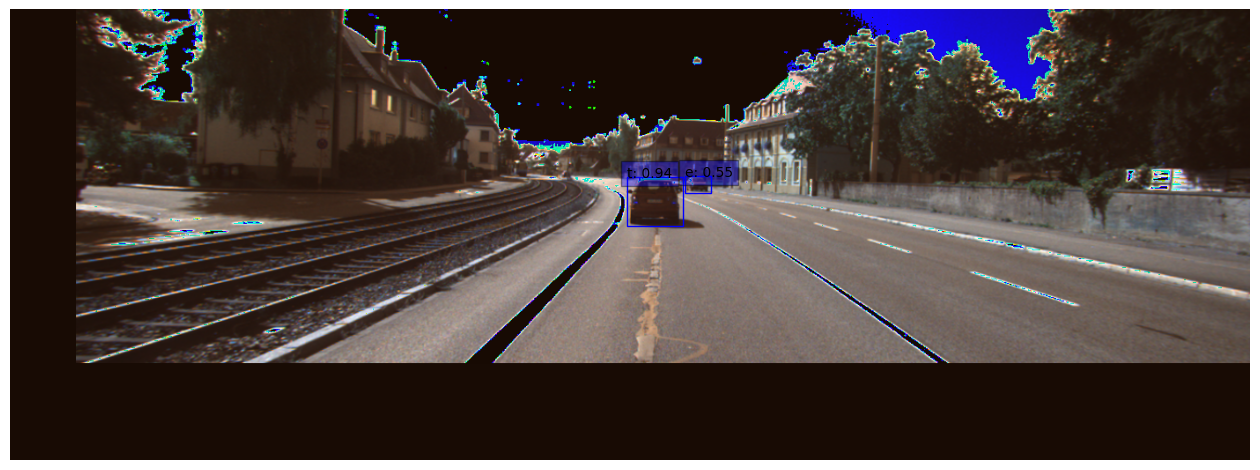

In [10]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(16, 16), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

def prepare_image(image):
    image, _, ratio = data_preprocess.resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

for sample in train_dataset.take(2):
    image = tf.cast(sample[0][1], dtype=tf.float32)
    predictions = model.predict(sample[0])
    detections = DecodePredictions(confidence_threshold = 0.5, num_classes = num_classes)(sample[0], predictions)
    num_detections = detections.valid_detections[1]
    image = image + 128
    image = tf.cast(image, tf.uint8)
    visualize_detections(
        image,
        detections.nmsed_boxes[1][:num_detections],
        'test',
        detections.nmsed_scores[1][:num_detections],
    )